In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [3]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/kaggle/input/emotion-recognition-dataset/data...,Happy
1,/kaggle/input/emotion-recognition-dataset/data...,Sad
2,/kaggle/input/emotion-recognition-dataset/data...,Happy
3,/kaggle/input/emotion-recognition-dataset/data...,Happy
4,/kaggle/input/emotion-recognition-dataset/data...,Neutral
...,...,...
15448,/kaggle/input/emotion-recognition-dataset/data...,Surprise
15449,/kaggle/input/emotion-recognition-dataset/data...,Sad
15450,/kaggle/input/emotion-recognition-dataset/data...,Happy
15451,/kaggle/input/emotion-recognition-dataset/data...,Neutral


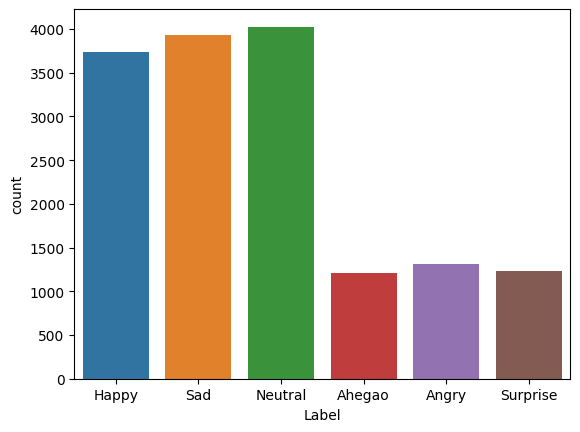

In [4]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 0);

In [5]:
train_data_dir =image_data
batch_size = 64
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 15453 files belonging to 6 classes.
Using 12363 files for training.
Found 15453 files belonging to 6 classes.
Using 3090 files for validation.


In [6]:
train_size = len(train)
val_size = len(validation)
total = train_size + val_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		194	(79.84%)
validation samples count:	49	(20.16%)
Total:				243	(100.00%)


In [7]:
class_names=train.class_names
class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

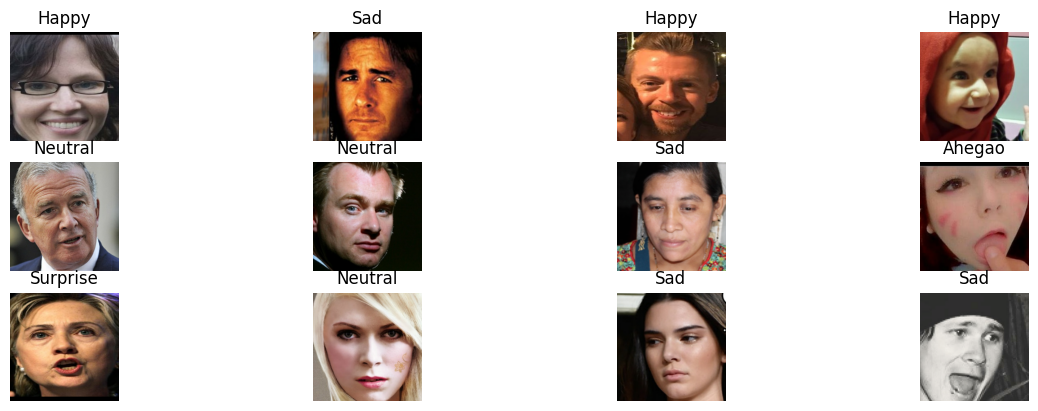

In [8]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(12, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
base_model = tf.keras.applications.EfficientNetV2M(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
keras_model.summary()

214201816/214201816 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, 7, 7, 1280)        53150388  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 6)                 376326    
                                                                 
Total params: 53526714 (204.19 MB)
Trainable params: 376326 (1.44 MB)
Non-trainable params: 53150388 (202.75 MB)
_________________________________________________________________


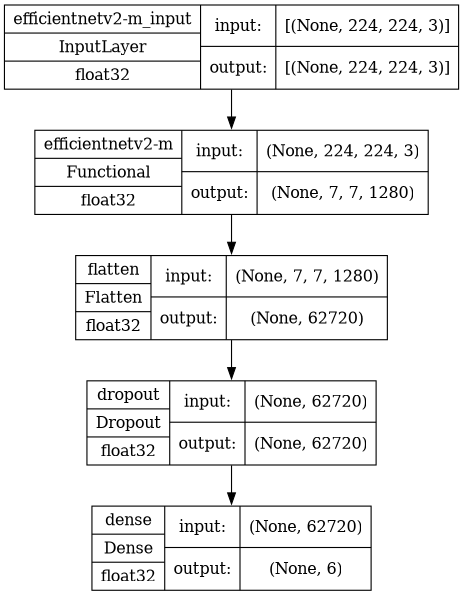

In [10]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [11]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [12]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [13]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=40,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/40


2023-12-12 18:13:39.792041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


194/194 [==============================] - 97s 360ms/step - loss: 2.1617 - accuracy: 0.5496 - val_loss: 1.1750 - val_accuracy: 0.7220
Epoch 2/40
194/194 [==============================] - 60s 303ms/step - loss: 1.6599 - accuracy: 0.6636 - val_loss: 1.1557 - val_accuracy: 0.7476
Epoch 3/40
194/194 [==============================] - 60s 303ms/step - loss: 1.5396 - accuracy: 0.6995 - val_loss: 0.9079 - val_accuracy: 0.7990
Epoch 4/40
194/194 [==============================] - 58s 295ms/step - loss: 1.4997 - accuracy: 0.7237 - val_loss: 1.1528 - val_accuracy: 0.7715
Epoch 5/40
194/194 [==============================] - 58s 294ms/step - loss: 1.4611 - accuracy: 0.7426 - val_loss: 0.9206 - val_accuracy: 0.8120
Epoch 6/40
194/194 [==============================] - 58s 294ms/step - loss: 1.3822 - accuracy: 0.7591 - val_loss: 0.9844 - val_accuracy: 0.8184
Epoch 7/40
194/194 [==============================] - 60s 304ms/step - loss: 1.3964 - accuracy: 0.7616 - val_loss: 0.8586 - val_accuracy: 0.8

In [14]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

49/49 [==============================] - 12s 213ms/step - loss: 0.6963 - accuracy: 0.8783
Test Loss = 0.6962658166885376
Test Accuracy = 0.8783171772956848


In [15]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,2.161749,0.549624,1.174983,0.722006
1,1.659859,0.663593,1.155675,0.747573
2,1.539603,0.699507,0.907910,0.799029
3,1.499691,0.723692,1.152783,0.771521
4,1.461093,0.742619,0.920611,0.811974
5,1.382211,0.759120,0.984390,0.818447
6,1.396410,0.761627,0.858566,0.837864
7,1.347455,0.775783,0.979663,0.831715
8,1.281958,0.785489,0.772675,0.861165
9,1.347999,0.786621,0.850389,0.855016


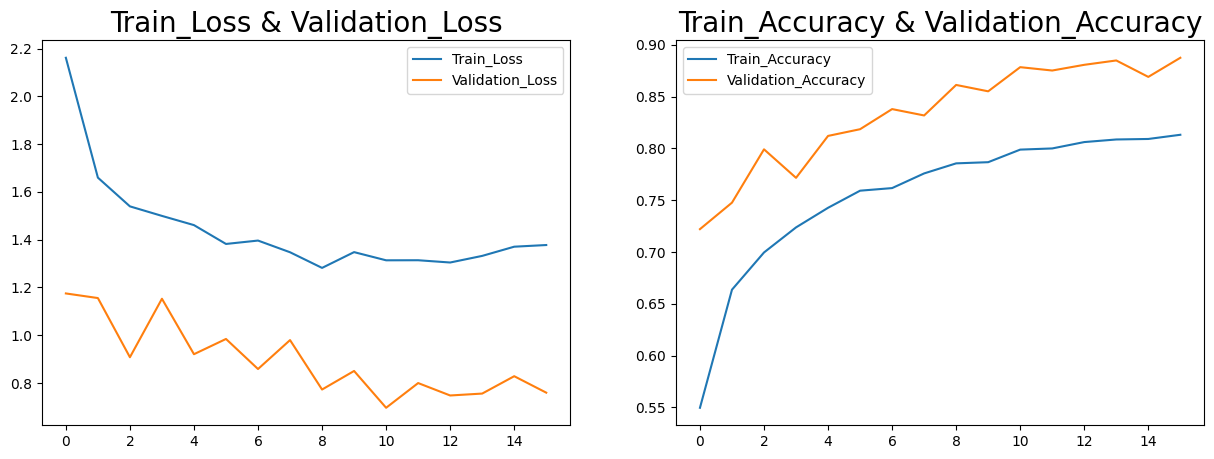

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()